In [1]:
import spacy
import pandas as pd
import numpy as np
import re

In [2]:
# Load the dataset
df = pd.read_csv("view_2078.csv")
len(df)

7585

In [55]:
list(df.columns)

['id',
 'Date of Encounter',
 'Type of encounter',
 'Purpose of encounter',
 'Age Range at Consultation',
 'Is the patient wearing a face mask during the consulation?',
 'Encounter ID 2',
 'Retire Encounter Record?',
 'Reason for Retiring Record',
 'Is Archived?',
 'Date Archived',
 'First Created',
 'Last Updated',
 'Complaint/s',
 'History of Illness',
 'Image for Complaint/Hx',
 'Neurologic',
 'Other Neurologic',
 'Pulmonary',
 'Other Pulmonary',
 'Cardiovascular',
 'Other Cardiovascular',
 'Skin/Gland',
 'Other Skin/Gland',
 'Gastrointestinal',
 'Other Gastrointestinal',
 'Musculoskeletal',
 'Other Musculoskeletal',
 'Psychiatric',
 'Other Psychiatric',
 'Temperature (C)',
 'Blood Pressure',
 'Pulse Rate (bpm)',
 'Oxygenation (%)',
 'Respiratory Rate',
 'Height (cm)',
 'Weight (kg)',
 'BMI',
 'Eye response',
 'Verbal response',
 'Motor response',
 'GCS',
 'Skin Status',
 'Skin Findings',
 'HEENT Status',
 'HEENT Findings',
 'Cardiovascular System Status',
 'Cardiovascular System Fi

In [3]:
# Filter the dataset to only include date of Encounter, Complaint/s, History of Illness
df.head()

,id,Date of Encounter,Type of encounter,Purpose of encounter,Age Range at Consultation,Is the patient wearing a face mask during the consulation?,Encounter ID 2,Retire Encounter Record?,Reason for Retiring Record,Is Archived?,...,Other Adverse Effects,Adverse Events,Did the patient get well?,Patient Disposition Summary,Type of Consultation,Income Classification,Follow-up Schedule,Identifying Physical Qualities,Record ID,Sex
0,6516480964fa61002775fdf3,2023-09-15T00:00:00+08:00,Outpatient,Check-up,20 - 29,False,7027-C4A3TDeUkE,False,NaN,False,...,NaN,|,NaN,Released | | | Did the patient get well:,NaN,NaN,2023-09-29T00:00:00+08:00,NaN,7027,Female
1,64c3894ccebb4d0028cd91e9,2023-07-22T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,5785-V5KGFNiHHz,False,NaN,False,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-07-28T00:00:00+08:00,NaN,5785,Male
2,64c38a2517e5110027622a8f,2023-07-22T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,5785-eI30WnP0WC,False,NaN,False,...,NaN,|,NaN,Released | | | Did the patient get well:,NaN,NaN,2023-07-28T00:00:00+08:00,NaN,5785,Male
3,64ca17a02be41a0027d286ed,2023-07-22T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,5699-4LLCGE0XPw,False,NaN,False,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-08-02T00:00:00+08:00,NaN,5699,Male
4,62bd47a9cb2f88001f93a9d6,2022-06-30T00:00:00+08:00,Outpatient,Check-up,60 - 69,False,775-nIwhR3zhzp,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2022-06-30T00:00:00+08:00,NaN,775,Male


[WHO defines ILI](https://www.who.int/teams/global-influenza-programme/surveillance-and-monitoring/case-definitions-for-ili-and-sari)  as "acute respiratory infection with: measured fever of ≥38 ⁰C and cough with onset within the last 10 days." 

The objectives of this analysis are as follows:
1. Filter cases according to the following rules:
- Mention of 'URTI', 'Upper Respiratory Tract Infection', 'CAP', 'Community Acquired Pneumonia', 'PCAP', 'Pediatric Community Acquired Pneumonia', 'fever', 'cough', or 'colds' in the chief complaint, history of patient illness, and diagnosis fields.
- Body temperature >= 37.8 deg. C. 

In [57]:
df[df["Preliminary Diagnosis/Final Diagnosis"].notna()]

,id,Date of Encounter,Type of encounter,Purpose of encounter,Age Range at Consultation,Is the patient wearing a face mask during the consulation?,Encounter ID 2,Retire Encounter Record?,Reason for Retiring Record,Is Archived?,...,Other Adverse Effects,Adverse Events,Did the patient get well?,Patient Disposition Summary,Type of Consultation,Income Classification,Follow-up Schedule,Identifying Physical Qualities,Record ID,Sex
5,62bdc5a74217b1001e68c59d,2022-06-30T00:00:00+08:00,Outpatient,Check-up,60 - 69,False,775-aBxKsqmB0N,False,NaN,False,...,None,None | None,NaN,Released | None | None | Did the patient get w...,NaN,NaN,2022-06-30T00:00:00+08:00,NaN,775,Male
9,651c061ffa80560027717c54,2023-09-19T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,4941-sjfUm2UYuk,False,NaN,False,...,NaN,|,NaN,Released | | | Did the patient get well:,NaN,NaN,2023-10-03T00:00:00+08:00,NaN,4941,Male
10,6540e2fcf6e2ab00273e1d62,2023-10-25T00:00:00+08:00,Outpatient,Check-up,10 - 19,False,7644-00v9wmsjVo,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-10-31T00:00:00+08:00,NaN,7644,Female
12,64f2c036c8efaa00298e4feb,2023-07-27T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,6028-i4pNWPmqMm,False,NaN,False,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-09-02T00:00:00+08:00,NaN,6028,Male
14,65234022ee9e20002790c5a5,2023-10-07T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,7199-ZfHTV4Rjj7,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-10-09T00:00:00+08:00,NaN,7199,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7580,64cfb2fb83ee5e00274d00fa,2023-07-04T00:00:00+08:00,Outpatient,New health issue,10 - 19,False,5991-NuGkwCh8f0,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-08-06T00:00:00+08:00,NaN,5991,Female
7581,6470ccfaeec5650027c1a906,2023-05-06T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,4456-oP4BHJRUHH,False,NaN,False,...,NaN,|,NaN,Released - under observation | | | Did the p...,NaN,NaN,2023-05-26T00:00:00+08:00,NaN,4456,Male
7582,62e193cd76092f002152680f,2022-07-26T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,1289-KETfqONNXk,False,NaN,False,...,NaN,|,NaN,Released | | | Did the patient get well:,NaN,NaN,2022-07-28T00:00:00+08:00,NaN,1289,Male
7583,62cd14dd7aee070021b0d07a,2022-07-12T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,939-dUTc9c1Q8c,False,NaN,False,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2022-07-12T00:00:00+08:00,NaN,939,Female


# Method of Training the Spacy Model

To train the spacy model, we will use the following steps:
- Perform regex matching to perform labeling of the entities. The regex matching will be done on the 'Complaint/s', 'History of Illness', and 'Preliminary Diagnosis/Final Diagnosis' fields.
- Use the labeled data to train the spacy model.


In [4]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

In [5]:
df_sample = df.sample(n=1000)


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_sample, test_size=0.2)
train

,Date of Encounter,Complaint/s,History of Illness,Preliminary Diagnosis/Final Diagnosis,Temperature (C)
4818,2023-04-25T00:00:00+08:00,“Anemic Ako”,3 days PTC patient had cough with whitish phle...,NaN,36.2
6810,2023-05-04T00:00:00+08:00,Dizziness,1 year PTC patient had dizziness. She is a kno...,NaN,36.4
4679,2022-09-01T00:00:00+08:00,Cough and Nasal Catarrh,Patient was noted by mother to have on and off...,NaN,36.5
2654,2022-08-02T00:00:00+08:00,dizziness,patient complained of dizziness with no other ...,BPPV\nHCVD,36.4
726,2023-08-23T00:00:00+08:00,Cough\nRunny nose,2 days PTC - cough and runny nose,URTI,36.4
...,...,...,...,...,...
312,2024-04-03T00:00:00+08:00,eye pain and pruritic eyelid,"Months pTC, patient started to have pruritic l...",T/C Eyelid dermatitis\nNUD,35.9
3236,2023-03-22T00:00:00+08:00,loose stools,2 days PTC patient had several episodes of loo...,NaN,NaN
167,2023-07-28T00:00:00+08:00,flank pain radiating to left leg,"1 month PTC, patient experienced right flank p...",Nephrolithiasis vs MSSPS,37.2
4116,2023-04-21T00:00:00+08:00,cough,3 days cough\nno fever or colds\nNo associated...,Bronchial Asthma,36.4


In [51]:
# Concatenate the column complaint
train['Complaint/s'] = train['Complaint/s'].fillna('')
train['History of Illness'] = train['History of Illness'].fillna('')
train['Preliminary Diagnosis/Final Diagnosis'] = train['Preliminary Diagnosis/Final Diagnosis'].fillna('')
train['text'] = train['Complaint/s'] + ' ' + train['History of Illness'] + ' ' + train['Preliminary Diagnosis/Final Diagnosis']

NameError: name 'train' is not defined

In [52]:
train['text'] = train['text'].apply(lambda x: re.sub(r'\s+', ' ', x))

NameError: name 'train' is not defined

In [53]:
train['text']

NameError: name 'train' is not defined

In [70]:
# join the text in df_sample
text = ' '.join(train['text'])
len(text)

437016

In [71]:
# remove (-) and (+) from text
text = re.sub(r'\(+', '', text)
text = re.sub(r'\)+', '', text)
text = re.sub(r'\-+', '', text)
text = re.sub(r'\s+', ' ', text)
text

'“Anemic Ako” 3 days PTC patient had cough with whitish phlegm associated with throat itchiness and verbalized “anemic ako” Dizziness 1 year PTC patient had dizziness. She is a known hypertensive and is maintained on Amlodipine and takes Catapres. Cough and Nasal Catarrh Patient was noted by mother to have on and off cough and nasal catarrh dizziness patient complained of dizziness with no other associated signs and symptoms. She is a known hypertensive maintained on Losartan. BPPV HCVD Cough Runny nose 2 days PTC cough and runny nose URTI fair appetite Patient was noted to have fair appetite. 2 days PTC she had nonproductive cough. Cough 4 days PTC, patient had cough with whitish phlegm, throat itchiness and fair appetite. urti vs pcap Cough epigastric pain 1 week history of epigastric pain, characterized as crampy, relieved by antacids. There was associated nausea and reflux. No consult done. GERD r/o gallstone Nose bleeding Patient frequently experiences nose bleeding T/C nasal defe

In [72]:
def get_matches(text, pattern):
    if pattern == "CAP":
        # Define a pattern to match whole words; assume "CAP" is a placeholder for a word.
        pattern = r'\bCAP\b'
    else:
        # Ensure that pattern matches whole words
        pattern = r'\b' + pattern + r'\w*'
    # Perform the match with case insensitivity
    matches = re.finditer(pattern, text, re.IGNORECASE)
    return [(match.start(), match.end(), match.group()) for match in matches]



In [73]:
def annotate_entities(text, pattern, label):
    matches = get_matches(text, pattern)
    entities = []
    labeled_texts = []
    for start, end, matched_text in matches:
        entities.append((start, end, label))
        labeled_texts.append((start, end, matched_text))
    return entities, labeled_texts

In [74]:
# Annotate the entities
symptoms = ['fever', 'cough', 'colds']
diseases = ['URTI', 'Upper Respiratory Tract Infection', 'CAP', 'Community Acquired Pneumonia', 'PCAP']
ILI = symptoms + diseases

all_entities = []
all_labeled_texts = []

for disease in ILI:
    entities, labeled_texts = annotate_entities(text, disease, 'ILI')
    all_entities.extend(entities)
    all_labeled_texts.extend(labeled_texts)

list_label = [label for (_, _, label) in all_labeled_texts]
np.unique(list_label)

array(['CAP', 'COLDS', 'COUGH', 'Cap', 'Colds',
       'Community Acquired Pneumonia', 'Community acquired pneumonia',
       'Cough', 'FEVER', 'Fever', 'PCAP', 'PCAPA', 'PCAPB', 'PCAPLR',
       'PCAPLow', 'PCAPrecovered', 'Pcap', 'PcapB',
       'UPPER RESPIRATORY TRACT INFECTION', 'URTI', 'URTIResolved',
       'URTIResolving', 'URTIresolvig', 'URTIresolving', 'URTi',
       'Upper Respiratory Tract Infection',
       'Upper Respiratory Tract Infections',
       'Upper Respiratory tract infection',
       'Upper respiratory tract infection', 'UrTI', 'Urti', 'Urticaria',
       'Urtiresolved', 'Urtiresolving', 'cap', 'colds', 'coldst',
       'community acquired pneumonia', 'cough', 'coughed', 'coughing',
       'coughs', 'coughyellowish', 'fever', 'feverish', 'pcap', 'uRTI',
       'upper respiratory tract infection', 'urti', 'urticarial'],
      dtype='<U34')

In [50]:
list_label

NameError: name 'list_label' is not defined

In [76]:
text[47860:47865]

'yspep'

In [77]:
train_data = [(text, {'entities': all_entities})]
train_data

[('“Anemic Ako” 3 days PTC patient had cough with whitish phlegm associated with throat itchiness and verbalized “anemic ako” Dizziness 1 year PTC patient had dizziness. She is a known hypertensive and is maintained on Amlodipine and takes Catapres. Cough and Nasal Catarrh Patient was noted by mother to have on and off cough and nasal catarrh dizziness patient complained of dizziness with no other associated signs and symptoms. She is a known hypertensive maintained on Losartan. BPPV HCVD Cough Runny nose 2 days PTC cough and runny nose URTI fair appetite Patient was noted to have fair appetite. 2 days PTC she had nonproductive cough. Cough 4 days PTC, patient had cough with whitish phlegm, throat itchiness and fair appetite. urti vs pcap Cough epigastric pain 1 week history of epigastric pain, characterized as crampy, relieved by antacids. There was associated nausea and reflux. No consult done. GERD r/o gallstone Nose bleeding Patient frequently experiences nose bleeding T/C nasal de

In [ ]:
test_data = 

In [78]:
ner=nlp.get_pipe("ner")
ner

In [79]:
for _, annotations in train_data:
    for ent in annotations.get('entities'):
        print(ent)

(1099, 1104, 'ILI')
(1421, 1426, 'ILI')
(1897, 1902, 'ILI')
(2665, 2670, 'ILI')
(2774, 2779, 'ILI')
(3146, 3151, 'ILI')
(3852, 3857, 'ILI')
(3881, 3886, 'ILI')
(5595, 5600, 'ILI')
(7000, 7005, 'ILI')
(7041, 7046, 'ILI')
(8437, 8442, 'ILI')
(9701, 9706, 'ILI')
(9767, 9772, 'ILI')
(10747, 10752, 'ILI')
(11538, 11543, 'ILI')
(11631, 11636, 'ILI')
(11651, 11656, 'ILI')
(11900, 11905, 'ILI')
(11934, 11939, 'ILI')
(11972, 11977, 'ILI')
(12463, 12468, 'ILI')
(14089, 14094, 'ILI')
(14371, 14376, 'ILI')
(14651, 14656, 'ILI')
(14830, 14835, 'ILI')
(15722, 15727, 'ILI')
(16053, 16058, 'ILI')
(16635, 16640, 'ILI')
(16897, 16902, 'ILI')
(17937, 17942, 'ILI')
(18020, 18025, 'ILI')
(18489, 18494, 'ILI')
(18547, 18552, 'ILI')
(19570, 19575, 'ILI')
(19869, 19874, 'ILI')
(20904, 20909, 'ILI')
(21148, 21153, 'ILI')
(21760, 21765, 'ILI')
(22588, 22593, 'ILI')
(22973, 22978, 'ILI')
(23335, 23340, 'ILI')
(23586, 23591, 'ILI')
(23614, 23619, 'ILI')
(24063, 24068, 'ILI')
(24174, 24179, 'ILI')
(24204, 24209, '

In [80]:
for _, annotations in train_data:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

In [81]:
ner.labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'ILI',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

In [82]:
import spacy
from spacy.training import Example
import random
from spacy.util import minibatch, compounding


# Example function to segment text into smaller parts
def segment_text(text, max_length=2000):
    segments = []
    start = 0
    while start < len(text):
        end = start + max_length
        if end < len(text):
            end = text.rfind(' ', start, end) + 1
        segments.append(text[start:end])
        start = end
    return segments

def remove_overlaps(entities):
    # Sort entities by start position
    entities = sorted(entities, key=lambda x: x[0])
    non_overlapping = []
    last_end = -1
    for start, end, label in entities:
        if start >= last_end:
            non_overlapping.append((start, end, label))
            last_end = end
    return non_overlapping

# Training loop
pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# Disable other pipes and train
with nlp.disable_pipes(*unaffected_pipes):
    sizes = compounding(1.0, 4.0, 1.001)
    for itn in range(100):
        random.shuffle(train_data)
        losses = {}
        for text, annotations in train_data:
            segments = segment_text(text)
            offset = 0
            for segment in segments:
                doc = nlp.make_doc(segment)
                # Adjust annotations for the segment
                segment_entities = [(start - offset, end - offset, label) for start, end, label in annotations['entities']
                                    if start >= offset and end <= offset + len(segment)]
                segment_entities = remove_overlaps(segment_entities)  # Remove overlaps
                example = Example.from_dict(doc, {"entities": segment_entities})
                nlp.update([example], drop=0.5, losses=losses)
                offset += len(segment)
        print("Losses", losses)

# Save the trained model
nlp.to_disk("trained_spacy_model")

/home/miniloda/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "noted. Has myopia, has glasses but is not wearing ..." with entities "[(784, 789, 'ILI'), (793, 798, 'ILI'), (800, 805, ...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/miniloda/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "prior to consulting patient had a wound on her rig..." with entities "[(113, 118, 'ILI'), (142, 147, 'ILI'), (419, 424, ...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/miniloda/.local/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [

Losses {'ner': 1696.6607219940765}
Losses {'ner': 129.27609235519375}
Losses {'ner': 67.47323062350283}
Losses {'ner': 23.416257169668867}
Losses {'ner': 17.928344313311342}
Losses {'ner': 25.66383112380595}
Losses {'ner': 9.583606482041942}
Losses {'ner': 16.130582865193023}
Losses {'ner': 18.971126403326416}
Losses {'ner': 16.627713889021507}
Losses {'ner': 7.936800267364742}
Losses {'ner': 5.314817428259049}
Losses {'ner': 10.715930597704347}
Losses {'ner': 6.480560843432951}
Losses {'ner': 5.5138660855171775}
Losses {'ner': 9.035729245795453}
Losses {'ner': 5.940415808433791}
Losses {'ner': 10.148625788469356}
Losses {'ner': 7.998605150737335}
Losses {'ner': 12.690762805598043}
Losses {'ner': 4.73784183492444}
Losses {'ner': 1.9839529171633392}
Losses {'ner': 6.949432551539489}
Losses {'ner': 9.24962414187177}
Losses {'ner': 1.543477924604397}
Losses {'ner': 3.388067588678152}
Losses {'ner': 0.0030954800633411794}
Losses {'ner': 5.647079424654182}
Losses {'ner': 1.9701578585996968}

In [85]:
# add testing data
df_test = test
df_test['Complaint/s'] = df_test['Complaint/s'].fillna('')
df_test['History of Illness'] = df_test['History of Illness'].fillna('')
df_test['Preliminary Diagnosis/Final Diagnosis'] = df_test['Preliminary Diagnosis/Final Diagnosis'].fillna('')
df_test['text'] = df_test['Complaint/s'] + ' ' + df_test['History of Illness'] + ' ' + df_test['Preliminary Diagnosis/Final Diagnosis']
text = ' '.join(df_test['text'])

In [86]:
doc = nlp(text)
print(doc.ents)


(cough, cough, fever, fever, Urti, fever, cough, fever, cough, colds, Cough, colds, cough, colds, fever, upper respiratory tract infection, fever, fever, fever, cough, URTI, cough, URTI, cough, cough, Cough, cough, cough, fever, Cough, Cough, Cough, Cap, URTI, fever, cough, URTI, fever, fever, cough, URTI, fever, fever, cough, fever, cough, cough, colds, URTI, Cough, Cap, cough, colds, fever, URTI, cough, cough, PCAP, URTI, fever, fever, cough, fever, URTI, Cough, cough, fever, URTI, cough, fever, CAP, Cough, cough, fever, URTI, cough, cough, colds, fever, URTI, Cough, Fever, Cough, cough, CAP, fever, fever, fever, cough, cough, CAP, cough, Cough, cough, CAP, Cough, Pcap, fever, fever, cough, cough, urti, Cough, Cap, cough, cough, cough, cough, cough, urti, fever, URTI, cough, PCAP, URTI, Cough, cough, cough, cough, cough, cough, fever, cough, URTI, Fever, fever, cough, cap, Cough, Cap, cough, cough, Cough, Fever, fever, cough, PCAP, Cough, cough, fever, CAP, cough, colds, cough, fever

In [87]:
doc = nlp("The patient has Fever and Cough. The patient has URTI. The patient is suffering from BPPV. Upper back pain")
print([(ent.text, ent.label_) for ent in doc.ents])

[('Fever', 'ILI'), ('Cough', 'ILI'), ('URTI', 'ILI')]


In [88]:
keywords = ['fever', 'cough', 'colds', 'URTI', 'Upper Respiratory Tract Infection', 'CAP', 'Community Acquired Pneumonia', 'PCAP', 'Pediatric Community Acquired Pneumonia']
df_new = pd.DataFrame(columns=df.columns)

df_new

,Date of Encounter,Complaint/s,History of Illness,Preliminary Diagnosis/Final Diagnosis,Temperature (C),text


In [89]:
for rows in df.itertuples():
    text = str(rows[2]) + ' . ' + str(rows[3]) + ' . ' + str(rows[4])
    doc = nlp(text)
    entities = [ent.text.lower() for ent in doc.ents]  # Convert entity texts to lowercase
    # if entities is not empty
    

[]
['cough', 'cough', 'fever']
[]
['cough', 'cough']
[]
[]
[]
[]
[]
['colds']
[]
[]
['cough', 'cough', 'fever', 'cough', 'pcap']
[]
[]
[]
[]
['coughing', 'cough']
['cough', 'fever']
['cough', 'cough', 'cap']
[]
[]
['fever', 'fever']
['cough', 'cough', 'fever', 'colds', 'urti']
[]
[]
['cough', 'colds', 'cap']
[]
[]
['cough', 'cough', 'fever', 'pcap']
[]
[]
['fever']
['cough', 'colds', 'cough', 'colds', 'fever', 'cough', 'pcap']
[]
['fever']
[]
[]
['cough', 'cough', 'cap']
[]
[]
[]
['urti']
[]
['cough', 'colds', 'cough', 'urti']
[]
[]
['cough', 'colds', 'cough', 'colds', 'fever', 'cough', 'pcap']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['cough']
[]
[]
[]
[]
['cough', 'cough', 'cap']
[]
['cough', 'colds', 'fever', 'urti']
[]
[]
[]
['cough']
['cough', 'cough', 'fever']
['cough', 'fever']
[]
[]
['urti']
[]
[]
[]
['cough', 'cough', 'fever', 'cough', 'urti']
['cough', 'colds', 'fever', 'urti']
['cough', 'cough', 'fever', 'community acquired pneumonia']
['cough', 'cough', 'urti']
['urti']
['cough', 'cough'

KeyboardInterrupt: 

In [376]:
df_new

,Date of Encounter,Complaint/s,History of Illness,Preliminary Diagnosis/Final Diagnosis,Temperature (C)
0,2023-07-22T00:00:00+08:00,cough,"3 days PTC patient had cough, nasal catarrh an...",NaN,36.3
1,2023-07-22T00:00:00+08:00,cough,1 week PTC patient had cough and nasal catarrh.,NaN,36.0
2,2023-09-19T00:00:00+08:00,Nasal catarrh,NaN,Common colds,37.0
3,2023-07-27T00:00:00+08:00,cough,6 days PTC patient started to have productive ...,PCAP,37.3
4,2022-10-10T00:00:00+08:00,"""gina atake sang kulba""","~ 20 yrs PTC , pc witnessed a fight as she was...",Anxiety Reaction Secondary to A General Medica...,35.7
...,...,...,...,...,...
3583,2023-05-13T00:00:00+08:00,Cough,NaN,NaN,NaN
3584,2023-09-12T00:00:00+08:00,Fever,NaN,Urti,38.0
3585,2023-10-04T00:00:00+08:00,Cough,NaN,CAP,NaN
3586,2023-07-04T00:00:00+08:00,cough and colds,NaN,URTI,NaN


In [31]:
columns = [
    'Complaint/s', 
    'History of Illness', 
    'Preliminary Diagnosis/Final Diagnosis'
]
col = df_new.columns
df_new = pd.DataFrame(columns=df.columns)
counter = 0
labels = []
for col in columns:
    for i in range(len(df)):
        text = str(df[col][i])
        doc = nlp(text)
        entities = [ent.text.lower() for ent in doc.ents]
        if len(entities) > 0:
            labels.append(entities)
            df_new = pd.concat([df_new, pd.DataFrame([df.loc[i]])], ignore_index=True)
            counter += 1
len(df_new)

NameError: name 'nlp' is not defined

In [30]:
wrong_labels = []
lowered_keywords = [keyword.lower() for keyword in keywords]
for i in range(len(labels)):
    for label in labels[i]:
        if label not in lowered_keywords:
            wrong_labels.append(label)


NameError: name 'keywords' is not defined

/tmp/ipykernel_246817/2887072847.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(count_sorted.values()), y=list(count_sorted.keys()), orient='h', palette="Blues_d")  # Use a different color palette


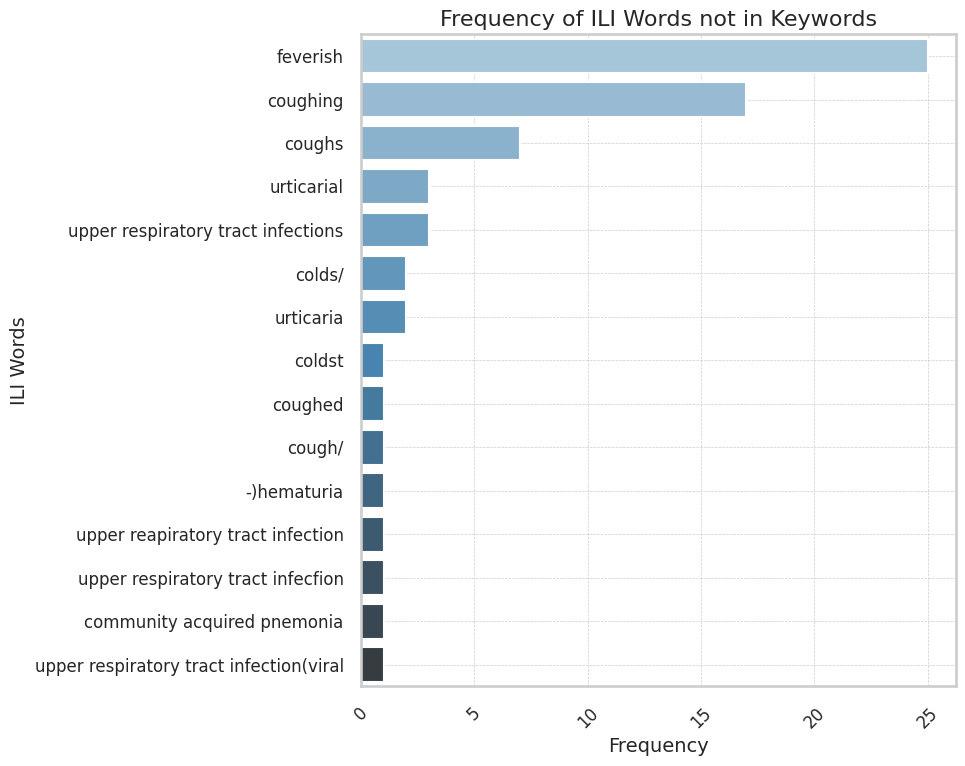

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style
sns.set_style("whitegrid")

# Increase the context for better readability
sns.set_context("talk")

# Assuming 'count_sorted' is your dictionary from previous code
count_sorted = {k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}

# Create the plot
plt.figure(figsize=(10, 8))  # Adjust the figure size
sns.barplot(x=list(count_sorted.values()), y=list(count_sorted.keys()), orient='h', palette="Blues_d")  # Use a different color palette

# Customize the plot
plt.xticks(rotation=45, fontsize=12)  # Rotate and set font size for x-ticks
plt.yticks(fontsize=12)  # Set font size for y-ticks
plt.title("Frequency of ILI Words not in Keywords", fontsize=16)  # Set title and font size
plt.xlabel("Frequency", fontsize=14)  # Set x-label and font size
plt.ylabel("ILI Words", fontsize=14)  # Set y-label and font size
plt.grid(True, which="both", ls="--", linewidth=0.5)  # Add gridlines

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the rotated x-tick labels
plt.show()

In [35]:
count ={'feverish': 25,
 'coughing': 17,
 'colds/': 2,
 'coughs': 7,
 'coldst': 1,
 'coughed': 1,
 'cough/': 1,
 'urticarial': 3,
 '-)hematuria': 1,
 'upper reapiratory tract infection': 1,
 'upper respiratory tract infections': 3,
 'upper respiratory tract infecfion': 1,
 'urticaria': 2,
 'community acquired pnemonia': 1,
 'upper respiratory tract infection(viral': 1} 
count

{'feverish': 25,
 'coughing': 17,
 'colds/': 2,
 'coughs': 7,
 'coldst': 1,
 'coughed': 1,
 'cough/': 1,
 'urticarial': 3,
 '-)hematuria': 1,
 'upper reapiratory tract infection': 1,
 'upper respiratory tract infections': 3,
 'upper respiratory tract infecfion': 1,
 'urticaria': 2,
 'community acquired pnemonia': 1,
 'upper respiratory tract infection(viral': 1}

In [7]:
import pandas as pd
df = pd.read_csv("view_2078.csv")

In [8]:
df_new.to_csv("test_ILI.csv", index=False)

NameError: name 'df_new' is not defined

In [9]:
df_new = pd.read_csv("test_ILI.csv")

In [10]:
df1 = pd.read_csv("ILI_estimate.csv")
df2 = df_new
len(df1)

/tmp/ipykernel_246817/2343397300.py:1: DtypeWarning: Columns (9,22,28,52,56,60,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("ILI_estimate.csv")


10404

In [11]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)

In [12]:
len(df1)

3634

In [13]:
df2

,id,Date of Encounter,Type of encounter,Purpose of encounter,Age Range at Consultation,Is the patient wearing a face mask during the consulation?,Encounter ID 2,Retire Encounter Record?,Reason for Retiring Record,Is Archived?,...,Other Adverse Effects,Adverse Events,Did the patient get well?,Patient Disposition Summary,Type of Consultation,Income Classification,Follow-up Schedule,Identifying Physical Qualities,Record ID,Sex
0,64c3894ccebb4d0028cd91e9,2023-07-22T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,5785-V5KGFNiHHz,False,NaN,False,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-07-28T00:00:00+08:00,NaN,5785,Male
1,64ca17a02be41a0027d286ed,2023-07-22T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,5699-4LLCGE0XPw,False,NaN,False,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-08-02T00:00:00+08:00,NaN,5699,Male
2,64f2c036c8efaa00298e4feb,2023-07-27T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,6028-i4pNWPmqMm,False,NaN,False,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-09-02T00:00:00+08:00,NaN,6028,Male
3,6540e5aaca8723002551948d,2023-10-25T00:00:00+08:00,Outpatient,Check-up,60 - 69,False,7649-tq9VgMErFr,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-10-31T00:00:00+08:00,NaN,7649,Female
4,64f1f433b2767d0028a35601,2023-08-27T00:00:00+08:00,Outpatient,Check-up,60 - 69,False,6512-GBLYPkL4hA,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-09-01T00:00:00+08:00,NaN,6512,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565,64005547f8bbfe0028aec2d6,2023-02-21T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,3578-hRqhr3gAnW,False,NaN,False,...,NaN,|,NaN,Released | | | Did the patient get well:,NaN,NaN,2023-03-02T00:00:00+08:00,NaN,3578,Male
7592,651a41979c6df40027d391e1,2023-09-13T00:00:00+08:00,Outpatient,Follow up on previous health issue,20 - 29,False,3447-3RRe8tFago,False,NaN,False,...,NaN,|,NaN,Released | | | Did the patient get well:,NaN,NaN,2023-10-02T00:00:00+08:00,NaN,3447,Male
7597,62dab39f6885be0021a8c94b,2022-07-22T00:00:00+08:00,Outpatient,Check-up,0 - 9,True,795-U5HUnfKmNZ,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2022-07-22T00:00:00+08:00,NaN,795,Female
7611,64f1e574309c1c00282368ad,2023-08-27T00:00:00+08:00,Outpatient,Check-up,10 - 19,False,6556-dPDLpnu3gM,False,NaN,False,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-09-01T00:00:00+08:00,NaN,6556,Male


In [14]:
import pandas as pd

# Assuming df1 and df2 are your DataFrames

# Merge df1 and df2 with an indicator and perform an outer join
merged_df = pd.merge(df1, df2, how='outer', indicator=True, on = "id")

# Filter rows that are only in df1
df1_not_in_df2 = merged_df[merged_df['_merge'] == 'left_only']

# Drop the indicator column
df1_not_in_df2 = df1_not_in_df2.drop(columns=['_merge'])

# If needed, reset the index
df1_not_in_df2.reset_index(drop=True, inplace=True)

# df1_not_in_df2 now contains rows from df1 that are not in df2

df2_not_in_df1 = merged_df[merged_df['_merge'] == 'right_only']
df2_not_in_df1 = df2_not_in_df1.drop(columns=['_merge'])
df2_not_in_df1.reset_index(drop=True, inplace=True)


In [18]:
FN = len(df1_not_in_df2)
FP = 4
TP = len(df1) - FN
TN = len(df2) - FP

In [19]:
df1_not_in_df2

,Unnamed: 0,id,Date of Encounter_x,Type of encounter_x,Purpose of encounter_x,Age Range at Consultation_x,Is the patient wearing a face mask during the consulation?_x,Encounter ID 2_x,Retire Encounter Record?_x,Reason for Retiring Record_x,...,Other Adverse Effects_y,Adverse Events_y,Did the patient get well?_y,Patient Disposition Summary_y,Type of Consultation_y,Income Classification_y,Follow-up Schedule_y,Identifying Physical Qualities_y,Record ID_y,Sex_y
0,5958,63bf9f4ab25151001282e4c4,2023-01-12T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,3048-F1PdYeN2cq,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3659,6348f0e3ba6c0a0022989821,2022-10-14T00:00:00+08:00,Outpatient,New health issue,40 - 49,False,1646-uqfipTVskx,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6337,64a571a001c9ba00294684b7,2023-07-03T00:00:00+08:00,Outpatient,New health issue,40 - 49,False,1130-eqNdSg2p9z,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3181,64c4d298837d620028a3db14,2023-07-06T00:00:00+08:00,Outpatient,Follow up on previous health issue,0 - 9,False,1309-KepriwesAX,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5902,649fc7c7ac17c00028b78b99,2023-06-23T00:00:00+08:00,Outpatient,Check-up,0 - 9,False,1768-YYqSSWxT7j,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1984,6530a935be9d48002852a54d,2023-10-17T00:00:00+08:00,Outpatient,Follow up on previous health issue,0 - 9,False,503-QVLuULiRMa,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,651984daa34fd8002955753f,2023-09-30T00:00:00+08:00,Outpatient,Check-up,70 - 79,False,7103-LgpOpHMwrL,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,459,62f0bb30fc1b050021d0f318,2022-08-08T00:00:00+08:00,Outpatient,Follow up on previous health issue,60 - 69,False,5-LG73Dqy59T,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,691,631dbe390bb087002167bc33,2022-08-27T00:00:00+08:00,Outpatient,New health issue,30 - 39,False,1885-bcKRVWWK1t,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,875,653b6da8926c940029b78e2a,2023-10-19T00:00:00+08:00,Outpatient,Check-up,40 - 49,False,7536-QXYKhSq82P,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (recall * precision) / (recall + precision)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall, precision, f1_score, accuracy

(0.9917446340121079,
 0.9988913525498891,
 0.9953051643192488,
 0.9953025697706549)

In [150]:
df1_not_in_df2["History of Illness_y"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
Name: History of Illness_y, dtype: object

In [151]:
len(df1_not_in_df2.columns)

220

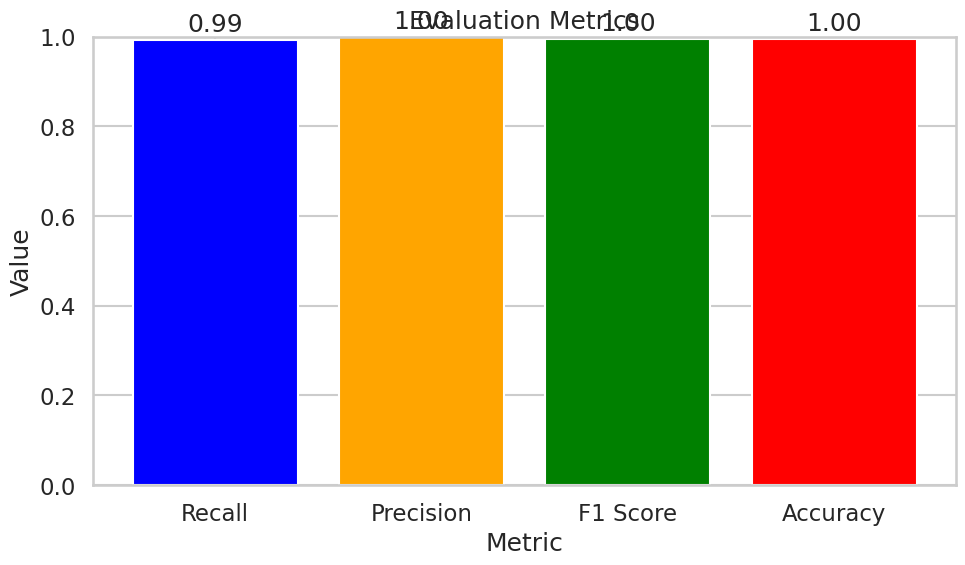

In [49]:
import matplotlib.pyplot as plt

# Step 1: Prepare the data
metrics = ['Recall', 'Precision', 'F1 Score', 'Accuracy']
values = [recall, precision, f1_score, accuracy]  # Use the actual values of recall, precision, f1_score, and accuracy

# Step 2: Set up the plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])

# Step 3: Customize the plot
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.ylim(0, 1)  # Assuming the values are between 0 and 1
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center')

# Step 4: Display the plot
plt.tight_layout()
plt.show()

In [119]:
len(df)

7585

In [120]:
len(merged_df)

3634

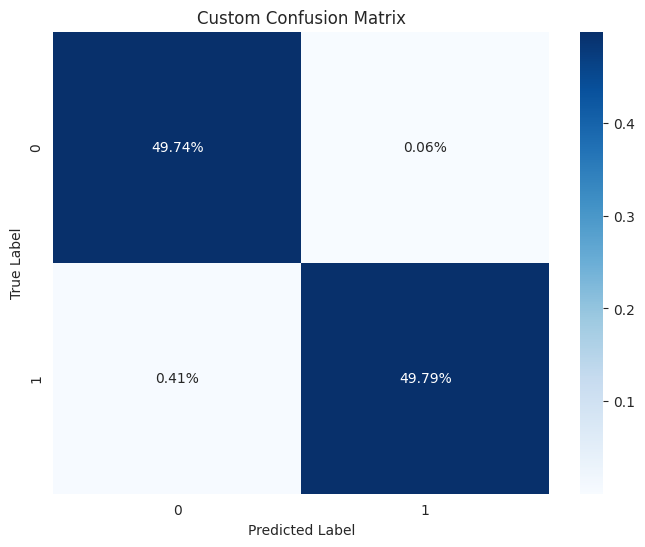

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Example custom confusion matrix
cf_matrix = np.array([[TN, FP],
                      [FN, TP]])

# Define labels (if needed)
#labels = ['True Positive', 'Class 1', 'Class 2']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Custom Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

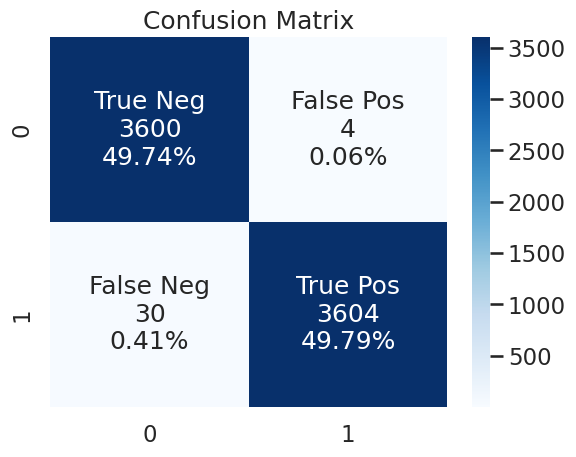

In [47]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

In [48]:
len(df)

7585